In [1]:
## Tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)
print(wiki.name)

wikipedia


In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

GROK_API_KEY = os.getenv("GROK_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [6]:
from langchain_community.tools import TavilySearchResults

tavily = TavilySearchResults()

/tmp/ipykernel_12830/3199068605.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [7]:
tavily.invoke("Provide me the recent news on AI")

[{'title': 'The 2025 AI Index Report | Stanford HAI',
  'url': 'https://hai.stanford.edu/ai-index/2025-ai-index-report',
  'content': 'Artificial Intelligence has leapt to the forefront of global discourse, garnering increased attention from practitioners, industry leaders, policymakers, and the general public. The diversity of opinions and debates gathered from news articles this year illustrates just how broadly AI is being investigated, studied, and applied. However, the field of AI is still evolving rapidly and even experts have a hard time understanding and tracking progress across the field. [...] Artificial Intelligence has leapt to the forefront of global discourse, garnering increased attention from practitioners, industry leaders, policymakers, and the general public. The diversity of opinions and debates gathered from news articles this year illustrates just how broadly AI is being investigated, studied, and applied. However, the field of AI is still evolving rapidly and eve

In [9]:
## Combine all the tools
tools = [arxiv, wiki, tavily]

In [10]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

In [11]:
llm.invoke("What is AI?")

AIMessage(content="<think>\nOkay, the user is asking, 'What is AI?' I need to start by defining AI clearly. Artificial Intelligence is a broad field, so I should mention that it's the simulation of human intelligence by machines. Maybe break it down into categories like machine learning, deep learning, natural language processing. But wait, the user might not be familiar with these terms, so I should explain them in simple terms.\n\nAlso, the user might be interested in how AI works. Should I talk about algorithms and data? Yes, because AI systems learn from data. Maybe mention supervised and unsupervised learning. But don't get too technical. Keep it conversational.\n\nApplications are important too. People might want to know where AI is used. Examples like virtual assistants, recommendation systems, autonomous vehicles. But I should be specific. Like mention Siri, Alexa, Netflix recommendations, self-driving cars. That makes it relatable.\n\nEthics and challenges? The user might not 

In [12]:
## bind the tools with llm
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
llm_with_tools.invoke("What is the latest news on machine learning?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest news on machine learning. I need to figure out which tool to use here. Let me check the available functions.\n\nFirst, there\'s the arxiv function, which is for querying arXiv papers. That\'s good for academic research but might not cover general news. Then there\'s Wikipedia, which is great for general knowledge but might not have the most up-to-date news. The third option is tavily_search_results_json, described as a search engine optimized for current events. That sounds like the best fit here because the user wants the latest news, which is likely to be covered by a news-focused search engine. \n\nSo I should use the tavily_search_results_json function with the query "latest news on machine learning". That should fetch the most recent and relevant news articles. I don\'t need to call the other functions since they\'re either for academic papers or general encyclopedic information,

In [14]:
llm_with_tools.invoke("What is the latest research on quantum computing?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest research on quantum computing. Let me think about which tool to use here. The available tools are arxiv, wikipedia, and tavily_search.\n\nArxiv is great for academic papers, so that\'s probably the best place to look for the latest research. Wikipedia might give general information but not the most recent studies. Tavily search is good for current events, but quantum computing research is often published in academic journals first.\n\nI should use the arxiv function with a query related to quantum computing. The parameters require a "query" string. Let me make sure the query is specific enough. Maybe "latest quantum computing research" or just "quantum computing" to get the most recent papers. I\'ll go with "quantum computing" as the query term.\n', 'tool_calls': [{'id': '4sf4p1s1r', 'function': {'arguments': '{"query":"quantum computing"}', 'name': 'arxiv'}, 'type': 'function'}]}, 

In [15]:
llm_with_tools.invoke("What is machine learning?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is machine learning?" I need to provide a clear and concise explanation. Let me start by recalling the basic definition. Machine learning is a subset of artificial intelligence that involves systems learning from data. But maybe I should elaborate a bit more.\n\nI should mention that instead of being explicitly programmed for tasks, machine learning algorithms build models from data. Examples like classification, regression, clustering could be helpful. Also, it\'s important to note the different types: supervised, unsupervised, and reinforcement learning.\n\nWait, the user might be a beginner, so I should keep it simple. Maybe start with the main idea, then break it down into key points. Let me check if I need to use any of the provided tools. The question is pretty general, so maybe the Wikipedia function would give an accurate overview. Let me query Wikipedia for "machine learning" to get a

### Workflow

In [16]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human Message or AI Message
from typing import Annotated ## Labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph

In [17]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [18]:
### Chatbot with langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [19]:
### Defining Nodes

def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

In [31]:
## Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
## if latest message result from assistant is tool call --> tools_condition routes to tool
## if latest messsage result from assistant is not a tool call --> tools_condition routes to END
tools_condition)
builder.add_edge("tools", END)

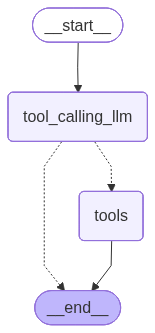

In [32]:
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages = graph.invoke({"messages": "1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (jcqxstfm1)
 Call ID: jcqxstfm1
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [35]:
messages = graph.invoke({"messages": "Hi, My name is Ankit"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi, My name is Ankit
================================== Ai Message ==================================

Hello Ankit! How can I assist you today? 😊


In [20]:
## Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
## if latest message result from assistant is tool call --> tools_condition routes to tool
## if latest messsage result from assistant is not a tool call --> tools_condition routes to END
tools_condition)
builder.add_edge("tools", "tool_calling_llm")

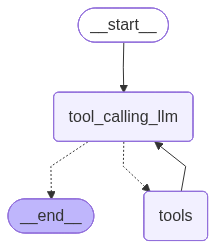

In [21]:
## Following is the ReAct Framework
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages = graph.invoke({"messages": "What is the recent AI News and Please tell me the recent research paper on quantum computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News and Please tell me the recent research paper on quantum computing
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (kjcnzkwvz)
 Call ID: kjcnzkwvz
  Args:
    query: recent AI news
  arxiv (0e5g2za56)
 Call ID: 0e5g2za56
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Artificial Intelligence - Latest AI News and Analysis - WSJ.com", "url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=AWEtsqeYhYi7qbs63qzRF0Uuk30JiPXzM4x3KsfCrxBrQY9Ju9mv8UWgWv8J&gaa_ts=69327ee1&gaa_sig=b64-nolH3AONrnX1GpvCizpYtSsuCMNlMsoX_rtmbXVGCHJOFbUKLY2E6Hlqmg_uopgT-CwKrlJO1xpSxau9dg%3D%3D", "content": "The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technolo

### Adding Memory to Agentic Graph

Langgraph has memory saver checkpointer which saves memory after every node. It stores the data in the form of dictionary in memory. It is only used for testing or debugging purpose for production we can use postgressaver or asyncpostgressaver. We need to pass this memory object while compiling

In [24]:
messages = graph.invoke({"messages": "Hello, My name is Ankit"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, My name is Ankit
================================== Ai Message ==================================

Hello Ankit! How can I assist you today?


In [25]:
messages = graph.invoke({"messages": "What is my name?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't have access to your personal information, including your name. If you'd like me to address you by name, please share it with me directly in your messages. Otherwise, I'll continue to respond to your questions and commands as instructed.


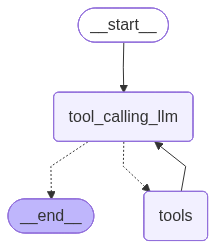

In [18]:
### Chatbot with langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

### Defining Nodes

def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
## if latest message result from assistant is tool call --> tools_condition routes to tool
## if latest messsage result from assistant is not a tool call --> tools_condition routes to END
tools_condition)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
## We need create a thread id for this but it will be automatically managed by the session in production
config = {"configurable": {"thread_id": "1"}}
response = graph.invoke({"messages": "Hi my name is Ankit"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is Ankit', additional_kwargs={}, response_metadata={}, id='ff6e36a0-9b0e-4dd5-b97b-f19394e1d558'),
  AIMessage(content='Hello Ankit! How can I assist you today?', additional_kwargs={'reasoning_content': "Okay, the user introduced himself as Ankit. I need to respond politely. Let me check if there's any specific function I need to use here. The tools provided are for arxiv, wikipedia, and tavily search. Since he just said his name, there's no indication he needs information from those sources. My response should be a simple greeting. No function calls necessary here. Just say hello and offer help.\n"}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 352, 'total_tokens': 453, 'completion_time': 0.255576678, 'completion_tokens_details': {'reasoning_tokens': 85}, 'prompt_time': 0.017227406, 'prompt_tokens_details': None, 'queue_time': 0.160252512, 'total_time': 0.272804084}, 'model_name': 'qwen/qwen3-32b', 'system

In [22]:
response["messages"][-1].content

'Hello Ankit! How can I assist you today?'

In [23]:
response = graph.invoke({"messages": "Hey what is my name"}, config=config)
response["messages"][-1].content

'Your name is Ankit.'

### Streaming

In [24]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [25]:
def superbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

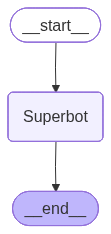

In [26]:
graph = StateGraph(State)

graph.add_node("Superbot", superbot)

graph.add_edge(START, "Superbot")
graph.add_edge("Superbot", END)

graph_builder = graph.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [27]:
## Invocation
config = {"configurable": {"thread_id": "1"}}
graph_builder.invoke({"messages": "Hi my name is Ankit and I like cricket"}, config)

{'messages': [HumanMessage(content='Hi my name is Ankit and I like cricket', additional_kwargs={}, response_metadata={}, id='d54f09ee-fc3b-4f5d-af23-7d796cc4cd0e'),
  AIMessage(content="<think>\nOkay, the user introduced themselves as Ankit and mentioned they like cricket. Let me start by acknowledging their introduction. I should respond in a friendly and welcoming manner. Maybe ask them about their favorite team or player to engage them further. Also, since cricket is a popular sport, perhaps suggest discussing recent matches or the IPL if they're interested. Keep the conversation open-ended to encourage them to share more. Need to make sure the response is enthusiastic and shows interest in their hobbies. Avoid any technical jargon and keep it casual. Let me put that all together in a natural way.\n</think>\n\nHi Ankit! Nice to meet you. Cricket is an awesome sport—love the energy and strategy it brings! Do you have a favorite team or player? Also, are you following any big upcoming

Methods: stream() and astream()

- These methods are sync and async methods for streaming back results

Additional parameters in streaming modes of graph state

- values: This streams the full state of the graph after each node is called
- updates: This streams only updated message to the state of graph after each node is called

In [28]:
## Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({"messages": "Hi my name is Ankit and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="<think>\nOkay, the user introduced himself as Ankit and mentioned he likes cricket. I need to respond in a friendly and engaging way.\n\nFirst, I should acknowledge his introduction and show interest in his hobby. Maybe ask about his favorite team or player to keep the conversation going.\n\nI should also consider if there are any recent cricket events or matches that might be relevant. But since I don't have real-time data, I should avoid mentioning specific dates or results unless it's general knowledge.\n\nAdditionally, I can offer to help with any cricket-related questions he might have, like rules, strategies, or player information. Keeping the tone positive and approachable is key here.\n\nI need to make sure the response is concise and not too long, but still provides enough options for him to choose how he wants to continue the conversation. Let me put that all together in a friendly manner.\n</think>\n\nHello Ankit! Nice to meet yo

In [29]:
for chunk in graph_builder.stream({"messages": "Hi my name is Ankit and I like cricket"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Ankit and I like cricket', additional_kwargs={}, response_metadata={}, id='cf93ce3f-525f-4c36-8e5f-6fd638a2c71a'), AIMessage(content="<think>\nOkay, the user introduced himself as Ankit and mentioned he likes cricket. I need to respond in a friendly and engaging way.\n\nFirst, I should acknowledge his introduction and show interest in his hobby. Maybe ask about his favorite team or player to keep the conversation going.\n\nI should also consider if there are any recent cricket events or matches that might be relevant. But since I don't have real-time data, I should avoid mentioning specific dates or results unless it's general knowledge.\n\nAdditionally, I can offer to help with any cricket-related questions he might have, like rules, strategies, or player information. Keeping the tone positive and approachable is key here.\n\nI need to make sure the response is concise and not too long, but still provides enough options for him to choo

In [30]:
## Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({"messages": "Hi my name is Ankit and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'Superbot': {'messages': [AIMessage(content="<think>\nOkay, the user's name is Ankit and he likes cricket. I should acknowledge his name and express interest in cricket. Maybe ask about his favorite team or a memorable match he's seen. I can also mention how cricket is popular in many countries and ask if he's followed any recent games or tournaments. Keep the conversation friendly and open-ended to encourage more interaction.\n</think>\n\nHi Ankit! Nice to meet you! 🏏 I know cricket is an amazing sport with so much passion and history. Do you have a favorite team or player? I'd love to hear what drew you to cricket in the first place!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 18, 'total_tokens': 147, 'completion_time': 0.364609338, 'completion_tokens_details': None, 'prompt_time': 0.000706499, 'prompt_tokens_details': None, 'queue_time': 0.051748911, 'total_time': 0.365315837}, 'model_name': 'qwen/qwen3-32b', 'system_fingerp

In [31]:
for chunk in graph_builder.stream({"messages": "I also like football"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is Ankit and I like cricket', additional_kwargs={}, response_metadata={}, id='78f0c0bc-b676-427f-96cf-a92cc573ae46'), AIMessage(content="<think>\nOkay, the user's name is Ankit and he likes cricket. I should acknowledge his name and express interest in cricket. Maybe ask about his favorite team or a memorable match he's seen. I can also mention how cricket is popular in many countries and ask if he's followed any recent games or tournaments. Keep the conversation friendly and open-ended to encourage more interaction.\n</think>\n\nHi Ankit! Nice to meet you! 🏏 I know cricket is an amazing sport with so much passion and history. Do you have a favorite team or player? I'd love to hear what drew you to cricket in the first place!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 18, 'total_tokens': 147, 'completion_time': 0.364609338, 'completion_tokens_details': None, 'prompt_time': 0.000706

In [32]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages": "Hi my name is Ankit and I like cricket"}, config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi my name is Ankit and I like cricket'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019aeda4-7d1b-7c10-86cf-617fb5ef1a9b', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is Ankit and I like cricket', additional_kwargs={}, response_metadata={}, id='62eac35f-4d51-48ee-9985-733fc7ea1391')]}}, 'name': 'Superbot', 'tags': ['graph:step:1'], 'run_id': '019aeda4-7d1c-7481-9f1b-1a61beab045d', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'Superbot', 'langgraph_triggers': ('branch:to:Superbot',), 'langgraph_path': ('__pregel_pull', 'Superbot'), 'langgraph_checkpoint_ns': 'Superbot:0839d279-2c59-3500-d896-226f36ed883c'}, 'parent_ids': ['019aeda4-7d1b-7c10-86cf-617fb5ef1a9b']}
{'event': 'on_chain_stream', 'run_id': '019aeda4-7d1c-7481-9f1b-1a61beab045d', 'name': 'Superbot', 'tags': ['graph:step:1'], 'metadata': {'thre